In [150]:
# import librarires

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**EDA**

In [151]:
# load the data

path = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

data = pd.read_csv(path)

array([[<AxesSubplot: title={'center': 'median_house_value'}>]],
      dtype=object)

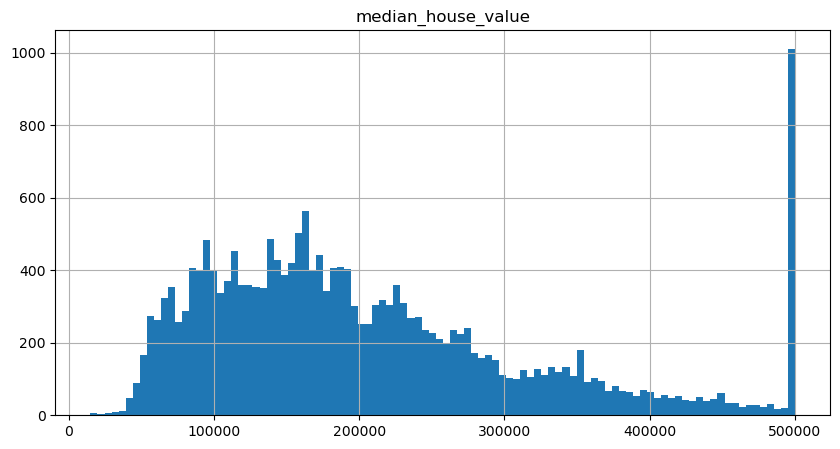

In [152]:
# histogram of median house value

data.hist(column='median_house_value', bins=100, figsize=(10, 5))

**Preparing the dataset**

In [153]:
subset = data[(data['ocean_proximity'] == 'INLAND') | (data['ocean_proximity'] == '<1H OCEAN')]
subset = subset[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']]
subset

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0
...,...,...,...,...,...,...,...,...,...
20635,39.48,-121.09,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,39.49,-121.21,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,39.43,-121.22,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,39.43,-121.32,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


**Question 1 - There's one feature with missing values. What is it?**

In [154]:
subset.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

total_bedrooms

**Question 2 - What's the median (50% percentile) for variable 'population'?**

In [155]:
subset.population.median()

1195.0

**Prepare and split the dataset**

Shuffle the dataset (the filtered one you created above), use seed 42.

Split your data in train/val/test sets, with 60%/20%/20% distribution.

Apply the log transformation to the median_house_value variable using the np.log1p() function.


In [156]:
def split_df(df, s):

    np.random.seed(s)
    n = len(df)
    val_num = int(0.2 * n)
    test_num = int(0.2 * n)
    train_num = n - val_num - test_num

    idx = np.arange(n)
    np.random.shuffle(idx)

    train = df.iloc[idx[:train_num]]
    val = df.iloc[idx[train_num:train_num+val_num]]
    test = df.iloc[idx[train_num+val_num:]]

    return train, val, test

**Question 3**

We need to deal with missing values for the column from Q1.

We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.

For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

In [157]:
def fill_with_zeros(df):
    df = df.copy()
    df['total_bedrooms'] = df['total_bedrooms'].fillna(0)
    return df

def fill_with_mean(df, df_mean):
    df = df.copy()
    na_mean = df_mean['total_bedrooms'].mean()
    df['total_bedrooms'] = df['total_bedrooms'].fillna(na_mean)
    return df

In [158]:
# log median_house_value

subset['median_house_value'] = np.log1p(subset['median_house_value'])

# split the data

train, val, test = split_df(subset, 42)

# fill the missing values with zeros

train_zeros = fill_with_zeros(train).reset_index(drop=True)
val_zeros = fill_with_zeros(val).reset_index(drop=True)
test_zeros = fill_with_zeros(test).reset_index(drop=True)

# fill the missing values with mean

train_mean = fill_with_mean(train, train)
val_mean = fill_with_mean(val, train)
test_mean = fill_with_mean(test, train)

In [159]:
def train_model(df):
    df = df.copy()
    y = df['median_house_value']
    del df['median_house_value']
    X = df.values
    ones = np.ones(len(X))
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [160]:
w0_zeros, w_zeros = train_model(train_zeros)
y_zeros = val_zeros.median_house_value.values
del val_zeros['median_house_value']
pred_zeros = w0_zeros + val_zeros.values.dot(w_zeros)

w0_mean, w_mean = train_model(train_mean)
y_mean = val_mean.median_house_value.values
del val_mean['median_house_value']
pred_mean = w0_mean + val_mean.values.dot(w_mean)

rmse_zeros = rmse(y_zeros, pred_zeros)
rmse_mean = rmse(y_mean, pred_mean)

print(round(rmse_zeros,2), round(rmse_mean,2))

0.34 0.34


No difference

**Question 4**

Now let's train a regularized linear regression.

For this question, fill the NAs with 0.

Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].

Use RMSE to evaluate the model on the validation dataset.

Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?


In [161]:
train_reg = fill_with_zeros(subset).reset_index(drop=True)
val_reg = fill_with_zeros(subset).reset_index(drop=True)
test_reg = fill_with_zeros(subset).reset_index(drop=True)

In [162]:
val_reg

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866
1,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657
2,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574
3,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971
4,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196
...,...,...,...,...,...,...,...,...,...
15682,39.48,-121.09,25.0,1665.0,374.0,845.0,330.0,1.5603,11.265758
15683,39.49,-121.21,18.0,697.0,150.0,356.0,114.0,2.5568,11.252872
15684,39.43,-121.22,17.0,2254.0,485.0,1007.0,433.0,1.7000,11.432810
15685,39.43,-121.32,18.0,1860.0,409.0,741.0,349.0,1.8672,11.346883


In [163]:
def train_model_reg(df, r):
    df = df.copy()
    y = df['median_house_value']
    del df['median_house_value']
    X = df.values
    ones = np.ones(len(X))
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [164]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_model_reg(train_reg, r=r)
    y = val_reg.median_house_value.values
    val_reg2 = val_reg.copy()
    del val_reg2['median_house_value']
    pred = w0 + val_reg2.values.dot(w)
    score = rmse(y, pred)
    print(r, round(score,3))

0 0.338
1e-06 0.338
0.0001 0.338
0.001 0.338
0.01 0.338
0.1 0.338
1 0.341
5 0.344
10 0.345


**Question 5**

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.

Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution.

Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.

Round the result to 3 decimal digits (round(std, 3))

In [167]:
seed_results = []

def seed_check(df):

    for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

        train, val, test = split_df(df, s)

        train = fill_with_zeros(train).reset_index(drop=True)
        val = fill_with_zeros(val).reset_index(drop=True)
        test = fill_with_zeros(test).reset_index(drop=True)

        w0, w = train_model(train)
        y = val.median_house_value.values
        del val['median_house_value']
        pred = w0 + val.values.dot(w)

        score = rmse(y, pred)

        seed_results.append(score)

    return seed_results

In [168]:
rmse_results = seed_check(subset)

round(np.std(rmse_results),3)

0.005

**Question 6**

Split the dataset like previously, use seed 9.

Combine train and validation datasets.

Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [171]:
test, val, train = split_df(subset, 9)

train_val = pd.concat([train, val])

train_val = fill_with_zeros(train_val).reset_index(drop=True)
test = fill_with_zeros(test).reset_index(drop=True)

w0, w = train_model_reg(train_val, r=0.001)
y = test.median_house_value.values
del test['median_house_value']
pred = w0 + test.values.dot(w)

score = rmse(y, pred)
score

0.34153786797318764